In [ ]:
# Install necessary libraries
!pip install datasets transformers torch torchvision efficientnet_pytorch

# Load the dataset
from datasets import load_dataset

dataset = load_dataset("deepghs/nsfw_detect")

# Check the class distribution
print(dataset['train'].features['label'].names)  # Check the labels
print(dataset['train'].unique('label'))  # Unique label values
print(dataset['train'].features['label'].int2str)  # Class mapping

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=ed74d760b6692c7f4bff57f81b40276415877676add567e54e2b5f298e80e58d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/28000 [00:00<?, ? examples/s]

['drawings', 'hentai', 'neutral', 'porn', 'sexy']
[0, 1, 2, 3, 4]
<bound method ClassLabel.int2str of ClassLabel(names=['drawings', 'hentai', 'neutral', 'porn', 'sexy'], id=None)>


In [ ]:
!pip install datasets transformers torch torchvision efficientnet_pytorch

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from efficientnet_pytorch import EfficientNet

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224, the input size for EfficientNet
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.RandomGrayscale(p=0.1),  # Randomly convert images to grayscale
])

# Custom function to apply transformations
def preprocess_function(examples):
    examples['image'] = [transform(image) for image in examples['image']]
    return examples

# Apply preprocessing transformations to the entire dataset
dataset = dataset.with_transform(preprocess_function)

In [ ]:

from datasets import Dataset, DatasetDict

# Define the ranges for each label (first 1000 examples per class)
ranges = {
    0: (0, 2199),
    1: (5600, 7799),  # Adjusted to start from 5600 for label 1
    2: (11200, 13399),  # Adjusted to start from 11200 for label 2
    3: (16800, 18999),  # Adjusted to start from 16800 for label 3
    4: (22400, 24599)   # Adjusted to start from 22400 for label 4
}

# Create an empty list to hold the selected examples
selected_indices = []

# Collect indices for each class
for label_id, (start, end) in ranges.items():
    # Ensure the end index does not exceed the dataset length
    end = min(end, len(dataset['train']))
    selected_indices.extend(range(start, end + 1))

# Select all examples based on the collected indices
subset_examples = dataset['train'].select(selected_indices)

# Create a new dataset from the selected examples
dataset = DatasetDict({
    'train': subset_examples
})


print(dataset)


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 11000
    })
})


In [ ]:
from datasets import DatasetDict

# Split the dataset into training (80%), validation (10%), and test (10%) sets
train_test_split = dataset['train'].train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
valid_test_split = train_test_split['test'].train_test_split(test_size=0.5, stratify_by_column='label', seed=42)

# Create a new DatasetDict with the splits
dataset = DatasetDict({
    'train': train_test_split['train'],
    'validation': valid_test_split['train'],
    'test': valid_test_split['test']
})

print(dataset)


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8800
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1100
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1100
    })
})


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchvision.models import efficientnet_b0
from torch import nn

# Load a pre-trained EfficientNet
model = efficientnet_b0(pretrained=True)

# Modify the final classifier to include dropout
num_classes = len(dataset['train'].features['label'].names)

# Modify the classifier to include dropout
model.classifier = nn.Sequential(
    nn.Dropout(p=0.6),  # Dropout with a probability of 0.5
    nn.Linear(model.classifier[1].in_features, num_classes)
)
model.load_state_dict(torch.load('/content/drive/MyDrive/model_state_epoch_3.pth'))
# Check if a GPU is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 40.4MB/s]
<ipython-input-7-426ea9519cb1>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses 

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Setting Up the Training Environment
import torch.optim as optim

# Define the loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)
optimizer.load_state_dict(torch.load('/content/drive/MyDrive/optimizer_state_epoch_3.pth'))




<ipython-input-8-89616504ce8b>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimizer.load_state_dict(torch.load('/content/drive/MyDrive/optimizer_state_epoch_3.pth'))


In [ ]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 1e-06
    maximize: False
    weight_decay: 0.001
)


In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-06

In [ ]:
for param_group in optimizer.param_groups:
    param_group['weight_decay'] = 0.001  # Set the new weight decay

In [ ]:
# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)  # Reduce learning rate every 1 epochs
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)# Creating Data Loaders


In [ ]:
# Creating Data Loaders
from torch.utils.data import DataLoader

# Define data loaders
train_loader = DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True, num_workers=2)
valid_loader = DataLoader(dataset['validation'], batch_size=64, shuffle=False, pin_memory=True, num_workers=2)
test_loader = DataLoader(dataset['test'], batch_size=64, shuffle=False, pin_memory=True, num_workers=2)


In [ ]:
# Training function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    for batch in train_loader:
        inputs, labels = batch['image'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / len(train_loader.dataset)
    return avg_loss, accuracy

# Validation function
def validate(model, device, valid_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in valid_loader:
            inputs, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(valid_loader)
    accuracy = correct / len(valid_loader.dataset)
    return avg_loss, accuracy

# Main training loop
num_epochs = 4
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
    valid_loss, valid_acc = validate(model, device, valid_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")

    # Save model, optimizer, and scheduler states with epoch number in the file name
    torch.save(model.state_dict(), f'/content/drive/MyDrive/model_state_epoch_{epoch+1}.pth')
    torch.save(optimizer.state_dict(), f'/content/drive/MyDrive/optimizer_state_epoch_{epoch+1}.pth')
    torch.save(scheduler.state_dict(), f'/content/drive/MyDrive/scheduler_state_epoch_{epoch+1}.pth')
    print("")





In [ ]:
def validate(model, device, valid_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in valid_loader:
            inputs, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(valid_loader)
    accuracy = correct / len(valid_loader.dataset)
    return avg_loss, accuracy

test_loss, test_acc = validate(model, device, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


In [ ]:
#Plotting confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Put the model in evaluation mode
model.eval()

# Store true labels and predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['image'].to(device), batch['label'].to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)



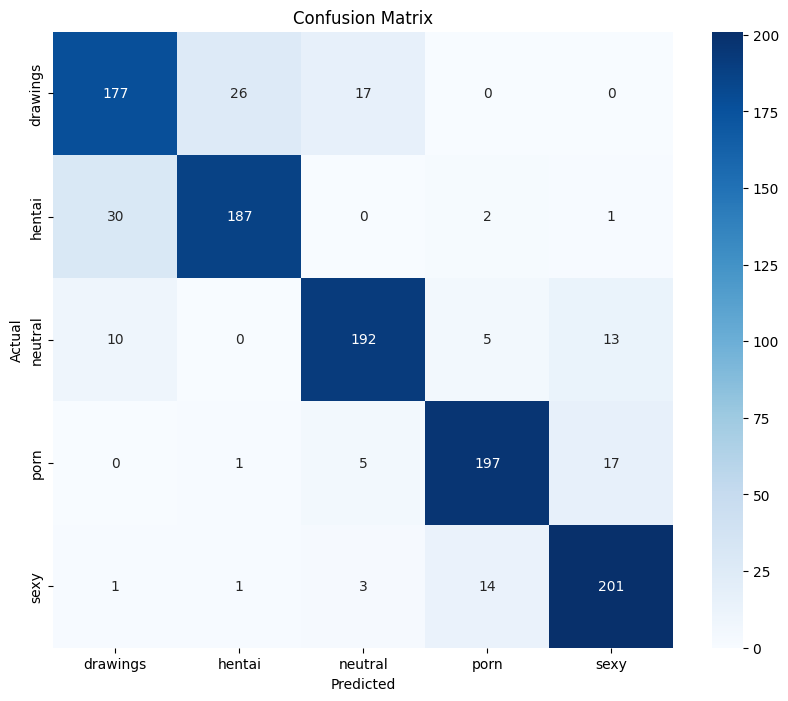

In [ ]:
# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset['train'].features['label'].names, yticklabels=dataset['train'].features['label'].names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=dataset['train'].features['label'].names)
print(report)


In [ ]:
#saving model to google drive

torch.save(model, '/content/drive/MyDrive/model.pth')
print("")
